In [ ]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:36155' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [5]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

# ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"
ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 
time_avg = ds.variables["ocean_time"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 17.9 s, sys: 3.47 s, total: 21.3 s
Wall time: 38.1 s


In [6]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [7]:
# import pickle as pk# load mask of south of the 1500m isobath: 

# # aaa = np.load(files_path + 'WAOM10_mask_shelf2_1500m.npy', allow_pickle=True)

# bbb = np.load(files_path + 'WAOM10_mask_shelf2.mask_1500m', allow_pickle=True)

# mask_shelf2 = ma.masked_where((bbb == True), np.ones(bbb.shape))
# ##mask_shelf_1500m = -(bbb-1)


In [8]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m', allow_pickle=True)

# mask_shelf2 = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))


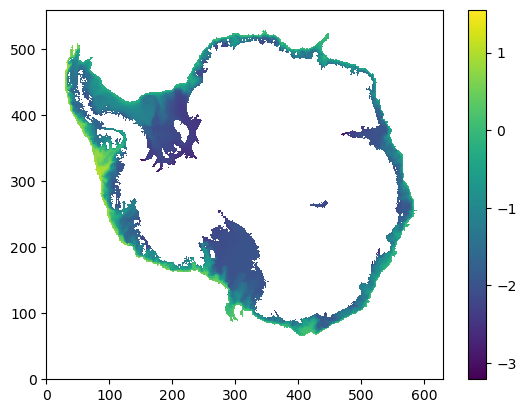

In [9]:
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, temp.isel(ocean_time=0, s_rho=0)))
plt.colorbar()

In [33]:
%%time

# ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"
ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


CPU times: user 16.8 s, sys: 3.21 s, total: 20.1 s
Wall time: 30.7 s


In [34]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_11-20yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=8, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=8)
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 117 ms, sys: 16 ms, total: 133 ms
Wall time: 107 ms


In [35]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
# dt = 5*86400 # 5-days in seconds
dt = 86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 365)
(31, 560, 630, 365)
(365, 31, 560, 630)
CPU times: user 145 ms, sys: 81.3 ms, total: 226 ms
Wall time: 179 ms


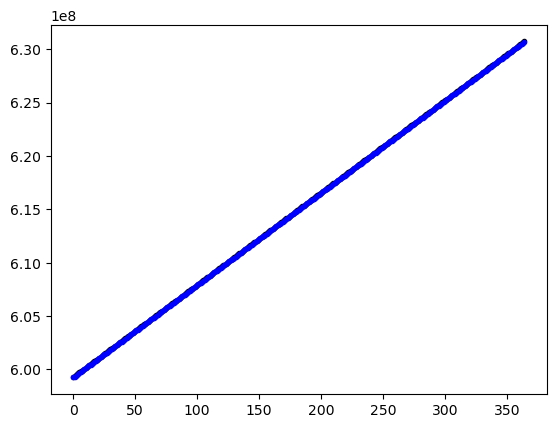

In [39]:
# check time stamps across his/avg variables to make sure they match:


# # print('1.', time_snap)
# print('2.', 2007+(time_snap[0]/86400/365))
# print('3.', time_ini)
# time_ini_datenum = (np.datetime64('2025-12-27')-np.datetime64('2007-01-01'))
# print('4.', time_ini_datenum/365, ', NOT days, years!')
# print('5.', (599616000-599184000)/86400) # 5-days!

# time_snap_np = time_snap.values
# time_ini_np = time_ini.values
# print(time_ini, time_snap_np.shape)
# time_snap2 = np.concatenate((time_ini_np,time_snap_np), axis=0)
# print(time_snap2.shape)

# # transform to DataArray
# time_snap = xr.DataArray(time_snap)
# time_ini = xr.DataArray(time_ini)

# print(time_snap.shape, time_ini.shape)

# # - append temp_ini to first time index in temp_snap and then do diff
# time_snap2 = xr.concat([time_ini,time_snap], 'ocean_time')

# print(time_snap2.shape, time_avg.shape)

plt.plot(np.arange(0,365),time_snap,'.k')
plt.plot(np.arange(0,365),time_avg,'.b')
# plt.plot(np.arange(0,365),time_snap2,'.r')



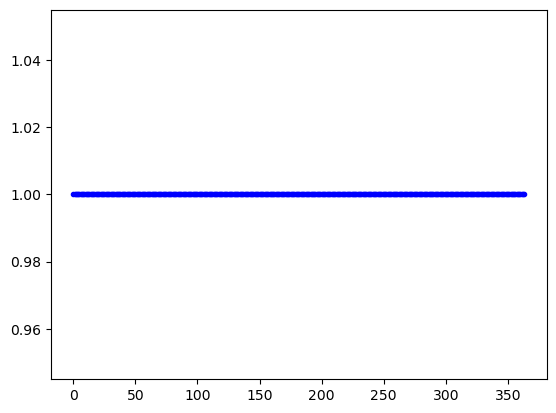

In [41]:
# calculate dt for avg/his timestamps:

dt_avg = np.diff(time_avg)
dt_snap = np.diff(time_snap)

plt.plot(np.arange(0,364),dt_avg/86400,'.b')

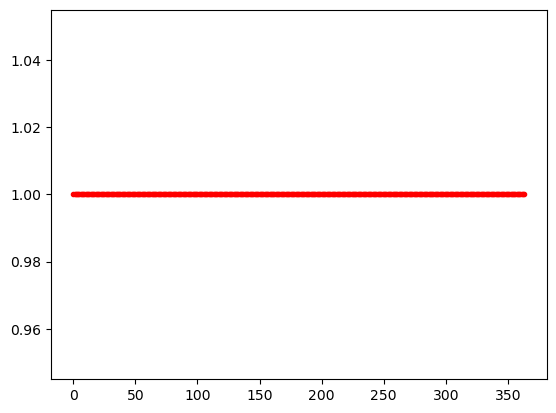

In [43]:
plt.plot(np.arange(0,364),dt_snap/86400,'.r')


In [44]:
# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000

# load ice draft to create masks
di = xr.open_dataset('/scratch/gi0/fbd581/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [45]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)


(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 25.6 s, sys: 53.3 s, total: 1min 18s
Wall time: 1min 17s


In [15]:
# this mask needs to be replaced by mask_shelf2 that uses the 1500-m contour

#mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))

# using masking during the computation instead; Ex: ma.masked_where(contour_masked_above == -1000, temp.isel(ocean_time=0, s_rho=0))

In [16]:
# # outdir = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# outdir = '/home/581/fbd581/cross_contour_tmp/'

# ds = xr.open_dataset(outdir + 'WAOM10extend_cross-1500m_vars4OHB.nc')
# mask_shelf = ds.Mask_shelf2
# ds.close()

In [17]:
# mask of the coast 
# mask_coast = ma.masked_where(np.isnan(temp_Rate2[0,-1,:,:]), np.ones(temp_Rate2[0,-1,:,:].shape))


In [46]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

In [47]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    ###shflux_area = shflux[mm,:]*area*mask_shelf*mask_coast
    # needs xarray masking:
    # shflux_area = shflux[mm,:].where(h < 1500)*area*mask_shelf2
    # shflux_area = shflux[mm,:]*mask_shelf2     # 18/07/2023
    # 20/07/2023
    shflux_masked = ma.masked_where(contour_masked_above == -1000, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    # temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    # temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    # temp_rate_vol[mm,:] = temp_rate_vint*area*mask_shelf2      # 18/07/2023
    # temp_rate_vol[mm,:] = ma.masked_where(contour_masked_above == -1000, temp_rate_vint*area) # 19/07/2023
    # temp_rate_vol[mm,:] = temp_rate_vint*area # 20/07/2023
    # 20/7/2023:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(contour_masked_above == -1000, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]),axis=1), axis=0)*Cp*rho0


CPU times: user 4min 43s, sys: 3min 2s, total: 7min 46s
Wall time: 14min 32s


In [48]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [49]:
print(temp_Rate.shape, dz.shape)

(365, 31, 560, 630) (365, 31, 560, 630)


In [50]:
print(shflux_area.shape, shflux_int.shape)
print(np.mean(shflux_int))#/area_sum)

(560, 630) (365,)
-67638951241634.61


In [51]:
print(temp_rate_vol.shape, temp_rate_int.shape)
print(np.mean(temp_rate_int))#/area_sum)

(365, 560, 630) (365,)
5091290306726.169


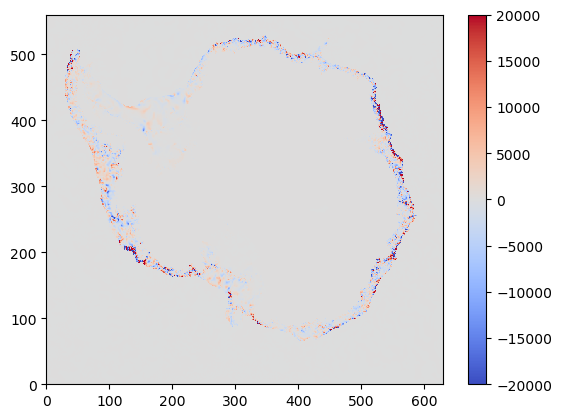

In [58]:
mm=35
# plt.pcolormesh(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]), vmin=-2e4, vmax=2e4, cmap='coolwarm')
plt.pcolormesh(temp_rate_vol[150,:], vmin=-2e4, vmax=2e4, cmap='coolwarm')
plt.colorbar()

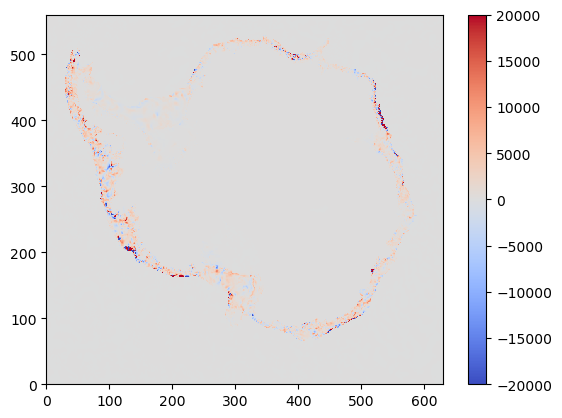

In [53]:
plt.pcolormesh(temp_rate_vol[-1,:], vmin=-2e4, vmax=2e4, cmap='coolwarm')
plt.colorbar()

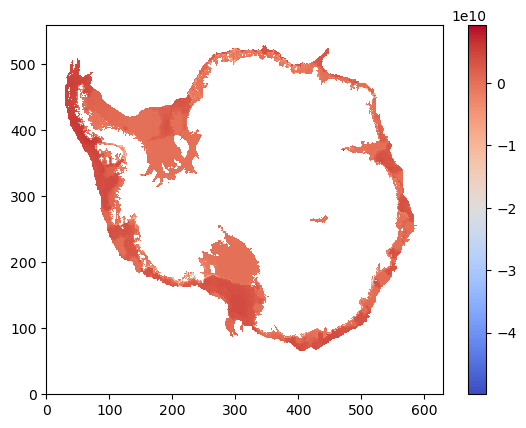

In [54]:
plt.pcolormesh(shflux_area, cmap='coolwarm')
plt.colorbar()

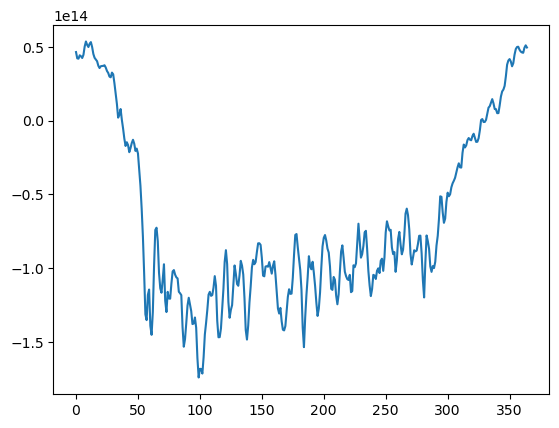

In [55]:
plt.plot(shflux_int)

Text(0, 0.5, 'W.m$^{-2}$')

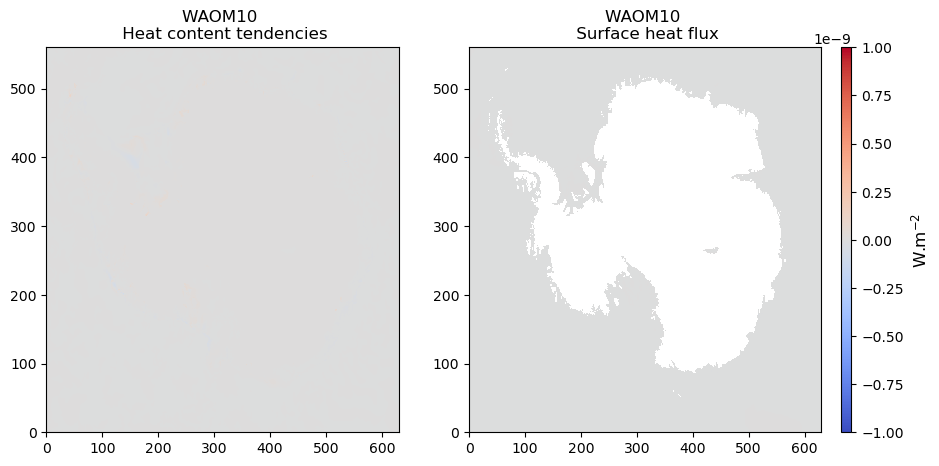

In [59]:
     
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

ax[0].title.set_text('WAOM10 \n Heat content tendencies')
# aa=ax[0].pcolormesh(np.nanmean(temp_rate_vol[1:-1], axis=0)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divide by 2.5 to be comparable to 4km maps (normalized by area instead?)
# aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1], axis=0),2.5)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divided by area
aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm')
# plt.colorbar(aa)

#  define 5-daily masked shflux:
shflux_masked = np.empty(shflux.shape)
for mm in np.arange(0,tlen):
    shflux_masked[mm,:,:] = ma.masked_where(contour_masked_above == -1000, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.


ax[1].title.set_text('WAOM10 \n Surface heat flux')
# bb=ax[1].pcolormesh(np.nanmean(shflux[1:-1], axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
bb=ax[1].pcolormesh(np.divide(np.nanmean(shflux_masked[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm') ##vmin=-100, vmax=100, cmap='coolwarm')

cax2 = plt.axes([0.92, 0.11, 0.01, 0.77])
cb = plt.colorbar(bb, cax=cax2, orientation='vertical')
cb.ax.set_ylabel('W.m$^{-2}$', fontsize=12)

# including comparison oldXnew estitemas below:
# cc=ax[1,0].pcolormesh(np.nanmean(temp_rate2_vol, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
# dd=ax[1,1].pcolormesh(np.nanmean(shflux2, axis=0), vmin=-100, vmax=100, cmap='coolwarm')

# # diff maps:
# ee=ax[2,0].pcolormesh((np.nanmean(temp_rate_vol, axis=0))-(np.nanmean(temp_rate2_vol, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')
# ff=ax[2,1].pcolormesh((np.nanmean(shflux, axis=0))-(np.nanmean(shflux2, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')




In [61]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.mean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.mean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.mean(temp_rate_int)-np.mean(shflux_int))*1e-12)



OHC tendency annual avg (TW):  5.091290306726169
Net sfc heat flux annual avg (TW):  -67.63895124163462
Residue (OHC - shflux) (TW):  72.73024154836078


In [62]:
temp_rate_int.shape

(365,)

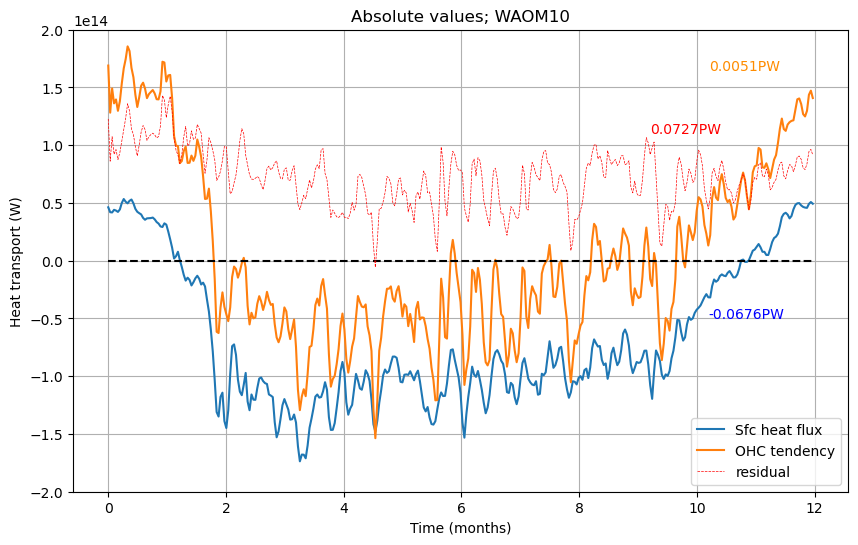

In [64]:
months=np.arange(0,365)*(1/30.41667)

fig, ax = plt.subplots(ncols=1, figsize = (10, 6))
plt.plot(months,shflux_int, label='Sfc heat flux')
plt.plot(months,temp_rate_int, label='OHC tendency')
# plt.plot(months,ohc_tend2,'--', label='OHC tendency old')
plt.plot(months,shflux_int*0,'--k')
plt.plot(months,temp_rate_int - shflux_int, '--r', label='residual',linewidth=0.5)
plt.ylim([-2e14,2e14])
# print annual avg values:
plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-15,decimals=4)) + 'PW', color='b')
plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-15,decimals=4)) + 'PW', color='darkorange')
plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-15,decimals=4)) + 'PW', color='red')

plt.grid()
plt.legend()
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [66]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")

CPU times: user 73.7 ms, sys: 29.2 ms, total: 103 ms
Wall time: 367 ms


In [67]:
shflux_int.shape

(365,)

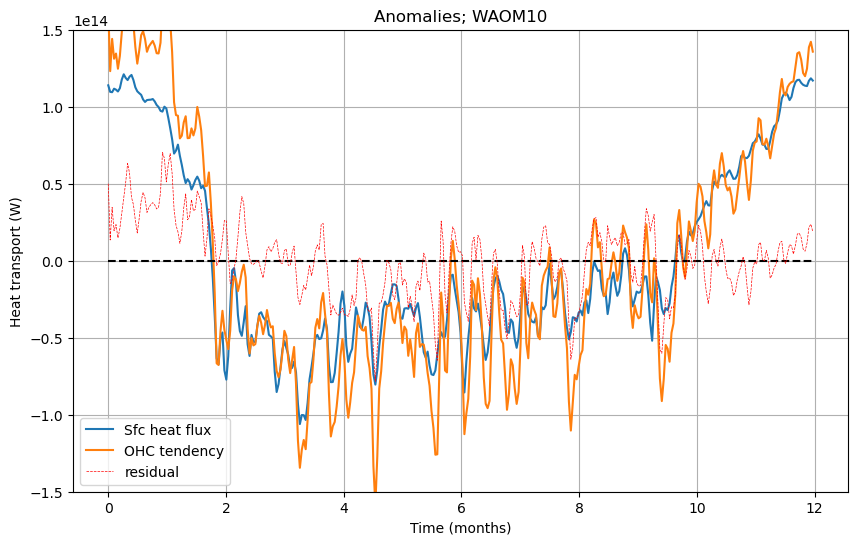

2023-08-23 10:50:02,014 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:34159'. Shutting down.
2023-08-23 10:50:02,019 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:41667'. Shutting down.
2023-08-23 10:50:02,022 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:36643'. Shutting down.
2023-08-23 10:50:02,024 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:37653'. Shutting down.
2023-08-23 10:50:02,024 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:38013'. Shutting down.
2023-08-23 10:50:02,024 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
torna

In [68]:
# calculate anomaly values:
ohc_tend = temp_rate_int - np.nanmean(temp_rate_int)
# ohc_tend2 = temp_rate2_int - np.nanmean(temp_rate2_int)
shflux_tend = shflux_int - np.nanmean(shflux_int)

fig, ax = plt.subplots(ncols=1, figsize = (10, 6))
plt.plot(months,shflux_tend, label='Sfc heat flux')
plt.plot(months,ohc_tend, label='OHC tendency')
# plt.plot(months,ohc_tend2,'--', label='OHC tendency old')
plt.plot(months,shflux_int*0,'--k')
plt.plot(months,ohc_tend - shflux_tend, '--r', label='residual',linewidth=0.5)
plt.ylim([-1.5e14,1.5e14])

plt.legend()
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Anomalies; WAOM10')
plt.grid()